1. I need complete python code used for the analysis.<br>
2. Need to make figures from the analysis.<br>
    a. Relative abundance<br>
    b. Alpha diversity analysis<br>
    c. Beta diversity analysis<br>
    d. Correlation analysis (like PCoA, PCA)<br>
    e. Network analysis between the sample<br>
    f. List of highly diverse microbes<br>
    g. Comparative analysis between amplicon types<br>

In [1]:
import os  # Operating system functions
import glob  # File path pattern matching
import wget  # Downloading files from the internet
import gzip  # Handling gzip-compressed files
import qiime2  # QIIME 2 library for analysis
import subprocess  # Running shell commands from Python
import numpy as np  # Numerical operations library
import pandas as pd  # Data manipulation library
import matplotlib.pyplot as plt  # Plotting library
# Set the Matplotlib backend to 'notebook'
%matplotlib notebook
import networkx as nx  # Network analysis library
from qiime2.plugins import demux  # Demultiplexing of sequence data
from qiime2.plugins import dada2  # Amplicon sequence variant inference
from qiime2.plugins import phylogeny  # Building phylogenetic trees
from qiime2.plugins import empress  # Visualizing phylogenetic trees
from qiime2.plugins import feature_table  # Feature table operations
from qiime2.plugins import diversity  # Calculating diversity metrics
from qiime2.plugins import feature_classifier  # Taxonomic classification
from qiime2.plugins import taxa  # Taxonomic analysis
from qiime2.plugins import emperor  # 3D PCoA visualization

In [2]:
def save_results(variable_name, output_dir):
    """
    Save QIIME 2 artifacts and visualizations from a variable containing matrices and visualizations.
    
    This function checks if the provided variable has the _fields attribute, indicating that
    it contains matrices and possibly visualizations. It then attempts to save each matrix
    or visualization in the provided output directory.
    
    Parameters:
        variable_name (object): The variable containing matrices and visualizations to be saved.
        output_dir (str): The directory where the matrices and visualizations will be saved as QIIME 2 artifacts.
    
    Returns:
        None

    Example usage:
        save_results(core_metrics, "output/diversity/")
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if the variable has the _fields attribute
    if hasattr(variable_name, '_fields'):
        # Iterate over each matrix in the _fields attribute
        for matrix_name in variable_name._fields:
            # Get the matrix attribute dynamically using getattr
            matrix = getattr(variable_name, matrix_name)
            # Check if the matrix is an Artifact instance
            if isinstance(matrix, qiime2.Artifact):
                # Save the matrix with the appropriate name
                out_filepath = os.path.join(output_dir, f"{matrix_name}.qza")
                matrix.save(out_filepath)
                print(f"Saved matrix {matrix_name} successfully at {out_filepath}.")
            # Check if the matrix is an Visualization instance
            elif isinstance(matrix, qiime2.Visualization):
                # Save the matrix with the appropriate name
                out_filepath = os.path.join(output_dir, f"{matrix_name}.qzv")
                matrix.save(out_filepath)
                print(f"Saved matrix {matrix_name} successfully at {out_filepath}.")
            else:
                print(f"Matrix {matrix_name} is not a valid Artifact or Visualization. Skipping.")
    else:
        print(f"Save failed! Provided {variable_name} objects could not be saved.")

## Import Data into Qiime2

In [3]:
data_dir = "data/"

In [4]:
def make_gz(data_dir):
    filenames = glob.glob(os.path.join(data_dir, "*/*.fastq"))
    # Iterate through the list of files
    for filename in filenames:
        output_path = filename + '.gz'
        with open(filename, 'rb') as f_in, gzip.open(output_path, 'wb') as f_out:
            f_out.writelines(f_in)
            
filenames = glob.glob(os.path.join(data_dir, "*/*.fastq.gz"))
if filenames:
    print("The files are already in gzip compression. Skipping...")
else:
    make_gz(data_dir)

The files are already in gzip compression. Skipping...


In [5]:
def get_paired_end_manifest_file(data_dir):
    """
    Generate a paired-end manifest file for DNA sequencing data.

    Args:
        data_dir (str): The directory containing the sequencing data files.

    Returns:
        str: The filepath of the generated paired-end manifest file.
    """
    # Create a directory to store the manifest file
    os.makedirs("input/", exist_ok=True)
    archaea_out_filepath = "input/archaea_paired_end_manifest.csv"
    bacteria_out_filepath = "input/bacteria_paired_end_manifest.csv"
    its_out_filepath = "input/its_paired_end_manifest.csv"
    
    # Get a list of all fastq files in the provided data directory
    filenames = glob.glob(os.path.join(data_dir, "*/*.fastq.gz"))
    archaea, bacteria, its = [], [], []
    for file_path in filenames:
        if "archaea" in file_path.lower():
            archaea.append(os.path.abspath(file_path))
        elif "bacteria" in file_path.lower():
            bacteria.append(os.path.abspath(file_path))
        else:
            its.append(os.path.abspath(file_path))
            
    # Create a dictionary to store sample IDs and their respective file paths
    archaea_path_dict = {}
    for path in archaea:
        filename = os.path.basename(path)
        base_dir = os.path.dirname(path)
        sample_id = filename.strip().split("_")[0]
        archaea_path_dict.setdefault(sample_id, []).append(os.path.join(base_dir, filename))
        
    bacteria_path_dict = {}
    for path in bacteria:
        filename = os.path.basename(path)
        base_dir = os.path.dirname(path)
        sample_id = filename.strip().split("_")[0]
        bacteria_path_dict.setdefault(sample_id, []).append(os.path.join(base_dir, filename))
        
    its_path_dict = {}
    for path in its:
        filename = os.path.basename(path)
        base_dir = os.path.dirname(path)
        sample_id = filename.strip().split("_")[0]
        its_path_dict.setdefault(sample_id, []).append(os.path.join(base_dir, filename))

    # Write the manifest file
    with open(archaea_out_filepath, "w") as ifile:
        ifile.write("sample-id,absolute-filepath,direction\n")
        for Id, filenames in archaea_path_dict.items():
            for filename in filenames:
                if "R1" in os.path.basename(filename).upper():
                    forward = filename
                else:
                    reverse = filename
            base_dir = os.path.dirname(forward)
            ifile.write(f"{Id},{forward},forward\n")
            ifile.write(f"{Id},{reverse},reverse\n")
            
    with open(bacteria_out_filepath, "w") as ifile:
        ifile.write("sample-id,absolute-filepath,direction\n")
        for Id, filenames in bacteria_path_dict.items():
            for filename in filenames:
                if "R1" in os.path.basename(filename).upper():
                    forward = filename
                else:
                    reverse = filename
            base_dir = os.path.dirname(forward)
            ifile.write(f"{Id},{forward},forward\n")
            ifile.write(f"{Id},{reverse},reverse\n")
            
    with open(its_out_filepath, "w") as ifile:
        ifile.write("sample-id,absolute-filepath,direction\n")
        for Id, filenames in its_path_dict.items():
            for filename in filenames:
                if "R1" in os.path.basename(filename).upper():
                    forward = filename
                else:
                    reverse = filename
            base_dir = os.path.dirname(forward)
            ifile.write(f"{Id},{forward},forward\n")
            ifile.write(f"{Id},{reverse},reverse\n")
        
    return archaea_out_filepath, bacteria_out_filepath, its_out_filepath

In [6]:
# Import data
archaea_manifest, bacteria_manifest, its_manifest = get_paired_end_manifest_file(data_dir)

archaea_sequences = qiime2.Artifact.import_data('SampleData[PairedEndSequencesWithQuality]',
                                        archaea_manifest,
                                        view_type='PairedEndFastqManifestPhred33')
os.makedirs("output", exist_ok=True)
archaea_sequences.save("output/archaea_sequences.qza")

bacteria_sequences = qiime2.Artifact.import_data('SampleData[PairedEndSequencesWithQuality]',
                                        bacteria_manifest,
                                        view_type='PairedEndFastqManifestPhred33')
bacteria_sequences.save("output/bacteria_sequences.qza")

its_sequences = qiime2.Artifact.import_data('SampleData[PairedEndSequencesWithQuality]',
                                        its_manifest,
                                        view_type='PairedEndFastqManifestPhred33')
its_sequences.save("output/its_sequences.qza")

'output/its_sequences.qza'

### Metadata

In [7]:
metadata = qiime2.Metadata.load('metadata.tsv')

### q2-feature-classifier

In [8]:
def get_classifier(url, out_dir):
    """
    Download a classifier from a URL and save it to the specified directory.
    
    This function creates the output directory if it doesn't exist, and then
    downloads the classifier from the provided URL to that directory.
    
    Parameters:
        url (str): The URL of the classifier to be downloaded.
        out_dir (str): The directory where the downloaded classifier will be saved.
    
    Returns:
        str: The file path to the downloaded classifier.
    
    Example usage:
        classifier_path = get_classifier("https://data.qiime2.org/2023.5/common/silva-138-99-nb-classifier.qza", 
        "classifiers/")
    """
    os.makedirs(out_dir, exist_ok=True)
    filename = os.path.basename(url)
    out_filepath = os.path.join(out_dir, filename)
    
    # Check if the file already exists before downloading
    if not os.path.exists(out_filepath):
        wget.download(url=url, out=out_dir)
        print(f"Downloaded classifier from {url} to {out_filepath}")
    else:
        print(f"Classifier already exists at {out_filepath}. Skipping download.")
    
    return out_filepath

# Example usage
# Make sure to replace these with actual URL and output directory
#classifier_path = get_classifier("https://data.qiime2.org/2023.5/common/silva-138-99-tax-515-806.qza",
#                                 "input/taxonomy_classifier/")


In [9]:
classifier_urls = {
    "silva_full": "https://data.qiime2.org/2023.5/common/silva-138-99-nb-classifier.qza",
    "silva_region": "https://data.qiime2.org/2023.5/common/silva-138-99-515-806-nb-classifier.qza",
    "gg_full": "https://data.qiime2.org/classifiers/greengenes/gg_2022_10_backbone_full_length.nb.qza",
    "gg_region": "https://data.qiime2.org/classifiers/greengenes/gg_2022_10_backbone.v4.nb.qza",
    "silva_weighted_full": "https://data.qiime2.org/2023.5/common/silva-138-99-nb-weighted-classifier.qza",
    "gg_weighted_full": "https://data.qiime2.org/2023.5/common/gg-13-8-99-nb-weighted-classifier.qza",
    "gg_weighted_region": "https://data.qiime2.org/2023.5/common/gg-13-8-99-515-806-nb-weighted-classifier.qza"}

#### [Note: Choose a classifier name from above dictionary]

In [10]:
classifier_path = get_classifier(classifier_urls["gg_weighted_region"], "taxonomy_classifier/")

unite_classifier_path = "taxonomy_classifier/unite_classifier.qza"

Classifier already exists at taxonomy_classifier/gg-13-8-99-515-806-nb-weighted-classifier.qza. Skipping download.


In [11]:
# Step 1: Import the UNITE sequences into QIIME 2
#sequences_artifact = qiime2.Artifact.import_data('FeatureData[Sequence]',
#                                                 'taxonomy_classifier/unite_sequences_97.fasta')

# Step 2: Import the taxonomy as a QIIME 2 Artifact
#taxonomy_artifact = qiime2.Artifact.import_data('FeatureData[Taxonomy]',
#                                                'taxonomy_classifier/unite_taxonomy_97.txt')

# Step 3: Train the classifier
#classifier = qiime2.plugins.feature_classifier.methods.fit_classifier_naive_bayes(
#    reference_reads=sequences_artifact,
#    reference_taxonomy=taxonomy_artifact).classifier

# Step 4: Save the trained classifier to a file
#classifier.save('taxonomy_classifier/unite_classifier.qza')


## Demultiplexing

In [12]:
os.makedirs("output/archaea", exist_ok=True)
os.makedirs("output/bacteria", exist_ok=True)
os.makedirs("output/its", exist_ok=True)

<IPython.core.display.Javascript object>


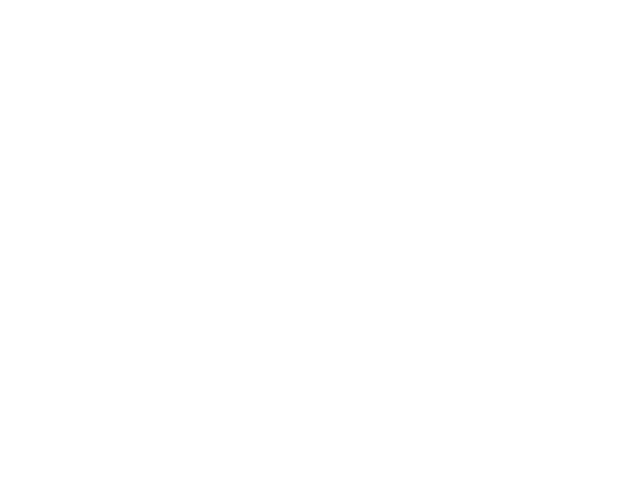

<visualization: Visualization uuid: a8fcb85a-e9b9-42ac-8db1-239dd398840c>

In [13]:
# Demux summarize
demux_summary = demux.visualizers.summarize(archaea_sequences)
demux_summary.visualization.save("output/archaea/qualities.qzv")
demux_summary.visualization

In [14]:
# Demux summarize
demux_summary = demux.visualizers.summarize(bacteria_sequences)
demux_summary.visualization.save("output/bacteria/qualities.qzv")
demux_summary.visualization

<visualization: Visualization uuid: fd5967de-5390-43f5-a4ae-58c1131a4303>

In [15]:
# Demux summarize
demux_summary = demux.visualizers.summarize(its_sequences)
demux_summary.visualization.save("output/its/qualities.qzv")
demux_summary.visualization

<visualization: Visualization uuid: f71c4d33-5c00-4adc-b0c8-59ee9fdb1dd0>

## Denoising and QC filtering

In [16]:
"""# DADA2 denoise-paired
dada2_denoised_a = dada2.methods.denoise_paired(demultiplexed_seqs=archaea_sequences,
                                              trunc_len_f=300,
                                              trunc_len_r=272,
                                              max_ee_f=10,
                                              max_ee_r=10,
                                              n_threads=4)"""

'# DADA2 denoise-paired\ndada2_denoised_a = dada2.methods.denoise_paired(demultiplexed_seqs=archaea_sequences,\n                                              trunc_len_f=300,\n                                              trunc_len_r=272,\n                                              max_ee_f=10,\n                                              max_ee_r=10,\n                                              n_threads=4)'

In [17]:
#save_results(dada2_denoised_a, "output/archaea/dada2/")

table_a = qiime2.Artifact.load("output/archaea/dada2/table.qza")
representative_sequences_a = qiime2.Artifact.load("output/archaea/dada2/representative_sequences.qza")
denoising_stats_a = qiime2.Artifact.load("output/archaea/dada2/denoising_stats.qza")

#table_a = dada2_denoised_a.table
#representative_sequences_a = dada2_denoised_a.representative_sequences
#denoising_stats_a = dada2_denoised_a.denoising_stats

In [18]:
#summary_table = feature_table.visualizers.summarize(table=table, sample_metadata=metadata)
#summary_rep_seq = feature_table.visualizers.tabulate_seqs(data=representative_sequences)

In [19]:
"""# DADA2 denoise-paired
dada2_denoised_b = dada2.methods.denoise_paired(demultiplexed_seqs=bacteria_sequences,
                                              trunc_len_f=285,
                                              trunc_len_r=264,
                                              max_ee_f=10,
                                              max_ee_r=10,
                                              n_threads=4)"""

'# DADA2 denoise-paired\ndada2_denoised_b = dada2.methods.denoise_paired(demultiplexed_seqs=bacteria_sequences,\n                                              trunc_len_f=285,\n                                              trunc_len_r=264,\n                                              max_ee_f=10,\n                                              max_ee_r=10,\n                                              n_threads=4)'

In [20]:
#save_results(dada2_denoised_b, "output/bacteria/dada2/")

table_b = qiime2.Artifact.load("output/bacteria/dada2/table.qza")
representative_sequences_b = qiime2.Artifact.load("output/bacteria/dada2/representative_sequences.qza")
denoising_stats_b = qiime2.Artifact.load("output/bacteria/dada2/denoising_stats.qza")

#table_b = dada2_denoised_b.table
#representative_sequences_b = dada2_denoised_b.representative_sequences
#denoising_stats_b = dada2_denoised_b.denoising_stats

In [21]:
"""# DADA2 denoise-paired
dada2_denoised_i = dada2.methods.denoise_paired(demultiplexed_seqs=its_sequences,
                                              trunc_len_f=300,
                                              trunc_len_r=300,
                                              max_ee_f=10,
                                              max_ee_r=10,
                                              n_threads=4)"""

'# DADA2 denoise-paired\ndada2_denoised_i = dada2.methods.denoise_paired(demultiplexed_seqs=its_sequences,\n                                              trunc_len_f=300,\n                                              trunc_len_r=300,\n                                              max_ee_f=10,\n                                              max_ee_r=10,\n                                              n_threads=4)'

In [22]:
#save_results(dada2_denoised_i, "output/its/dada2/")

table_i = qiime2.Artifact.load("output/its/dada2/table.qza")
representative_sequences_i = qiime2.Artifact.load("output/its/dada2/representative_sequences.qza")
denoising_stats_i = qiime2.Artifact.load("output/its/dada2/denoising_stats.qza")

#table_i = dada2_denoised_i.table
#representative_sequences_i = dada2_denoised_i.representative_sequences
#denoising_stats_i = dada2_denoised_i.denoising_stats

### Relative Abundance Plot

In [23]:
# Taxonomy classification
#reads = dada2_denoised.representative_sequences
# Path to the classifier
classifier = qiime2.Artifact.load(classifier_path)
taxa_classified = feature_classifier.methods.classify_sklearn(
    reads=representative_sequences_a,
    classifier=classifier,
    n_jobs=4
)
taxa_classified.classification.save("output/archaea/taxa.qza")

'output/archaea/taxa.qza'

In [24]:
# Taxa barplot
taxonomy = taxa_classified.classification
taxa_barplot = taxa.visualizers.barplot(
    table=table_a,
    taxonomy=taxonomy,
    metadata=metadata)

taxa_barplot.visualization.save("output/archaea/taxa_barplot.qzv")

'output/archaea/taxa_barplot.qzv'

In [25]:
taxa_barplot.visualization

<visualization: Visualization uuid: 39f96063-4fcc-4a2e-98b3-e95754a8c8a5>

In [26]:
taxa_classified = feature_classifier.methods.classify_sklearn(
    reads=representative_sequences_b,
    classifier=classifier,
    n_jobs=4
)
taxa_classified.classification.save("output/bacteria/taxa.qza")

# Taxa barplot
taxonomy = taxa_classified.classification
taxa_barplot = taxa.visualizers.barplot(
    table=table_b,
    taxonomy=taxonomy,
    metadata=metadata)

taxa_barplot.visualization.save("output/bacteria/taxa_barplot.qzv")

taxa_barplot.visualization

<visualization: Visualization uuid: c128961d-c257-43d0-856c-67262e7bd33f>

In [27]:
"""# Path to the classifier
classifier = qiime2.Artifact.load(unite_classifier_path)

taxa_classified = feature_classifier.methods.classify_sklearn(
    reads=representative_sequences_i,
    classifier=classifier,
    n_jobs=4
)
taxa_classified.classification.save("output/its/taxa.qza")

# Taxa barplot
taxonomy = taxa_classified.classification
taxa_barplot = taxa.visualizers.barplot(
    table=table_i,
    taxonomy=taxonomy,
    metadata=metadata)

taxa_barplot.visualization.save("output/its/taxa_barplot.qzv")

taxa_barplot.visualization"""

'# Path to the classifier\nclassifier = qiime2.Artifact.load(unite_classifier_path)\n\ntaxa_classified = feature_classifier.methods.classify_sklearn(\n    reads=representative_sequences_i,\n    classifier=classifier,\n    n_jobs=4\n)\ntaxa_classified.classification.save("output/its/taxa.qza")\n\n# Taxa barplot\ntaxonomy = taxa_classified.classification\ntaxa_barplot = taxa.visualizers.barplot(\n    table=table_i,\n    taxonomy=taxonomy,\n    metadata=metadata)\n\ntaxa_barplot.visualization.save("output/its/taxa_barplot.qzv")\n\ntaxa_barplot.visualization'

In [28]:
taxa_barplot = qiime2.Visualization.load("output/its/taxa_barplot.qzv")
taxa_barplot

<visualization: Visualization uuid: ef498091-7290-4457-9160-b49e65309928>

## Alpha Diversity

In [29]:
alpha_result = diversity.pipelines.alpha(table=table_a, metric='shannon')
os.makedirs("output/archaea/diversity/", exist_ok=True)
alpha_result.alpha_diversity.save("output/archaea/diversity/alpha_shannon.qza")

'output/archaea/diversity/alpha_shannon.qza'

In [30]:
# Perform alpha diversity group significance analysis
alpha_group_significance_shannon = diversity.visualizers.alpha_group_significance(
                                            alpha_diversity=alpha_result.alpha_diversity,
                                            metadata=metadata)

# Save the visualization
alpha_group_significance_shannon.visualization.save('output/archaea/diversity/shannon_alpha_group_significance.qzv')

'output/archaea/diversity/shannon_alpha_group_significance.qzv'

In [31]:
alpha_group_significance_shannon.visualization

<visualization: Visualization uuid: 5751be96-6624-47ea-be1d-d1c22ad75e95>

In [32]:
alpha_result = diversity.pipelines.alpha(table=table_b, metric='shannon')
os.makedirs("output/bacteria/diversity/", exist_ok=True)
alpha_result.alpha_diversity.save("output/bacteria/diversity/alpha_shannon.qza")

# Perform alpha diversity group significance analysis
alpha_group_significance_shannon = diversity.visualizers.alpha_group_significance(
                                            alpha_diversity=alpha_result.alpha_diversity,
                                            metadata=metadata)

# Save the visualization
alpha_group_significance_shannon.visualization.save('output/bacteria/diversity/shannon_alpha_group_significance.qzv')

alpha_group_significance_shannon.visualization

<visualization: Visualization uuid: e4e814aa-9b9f-47e5-ab21-19eb4d654cf6>

In [33]:
alpha_result = diversity.pipelines.alpha(table=table_i, metric='shannon')
os.makedirs("output/its/diversity/", exist_ok=True)
alpha_result.alpha_diversity.save("output/its/diversity/alpha_shannon.qza")

# Perform alpha diversity group significance analysis
alpha_group_significance_shannon = diversity.visualizers.alpha_group_significance(
                                            alpha_diversity=alpha_result.alpha_diversity,
                                            metadata=metadata)

# Save the visualization
alpha_group_significance_shannon.visualization.save('output/its/diversity/shannon_alpha_group_significance.qzv')

alpha_group_significance_shannon.visualization

<visualization: Visualization uuid: c9830add-bf2e-4c3f-9b23-577238d85c9e>

### Beta Diversity Analysis

In [34]:
# Calculate a distance matrix using a specific metric (e.g., Bray-Curtis)
distance_matrix_a = diversity.pipelines.beta(
                                table=table_a,
                                metric='braycurtis')

# Run beta group significance
beta_group_sig_result = diversity.visualizers.beta_group_significance(
                            distance_matrix=distance_matrix_a.distance_matrix,
                            metadata=metadata.get_column('condition'),
                            pairwise=True)

# Visualize beta group significance results
beta_group_sig_result.visualization.save('output/archaea/diversity/beta_group_significance_plot.qzv')

'output/archaea/diversity/beta_group_significance_plot.qzv'

In [35]:
beta_group_sig_result.visualization

<visualization: Visualization uuid: 05faf6da-9180-4da6-9b86-d00648c69400>

In [36]:
# Calculate a distance matrix using a specific metric (e.g., Bray-Curtis)
distance_matrix_b = diversity.pipelines.beta(
                                    table=table_b,
                                    metric='braycurtis')

# Run beta group significance
beta_group_sig_result = diversity.visualizers.beta_group_significance(
                            distance_matrix=distance_matrix_b.distance_matrix,
                            metadata=metadata.get_column('condition'),
                            pairwise=True)

# Visualize beta group significance results
beta_group_sig_result.visualization.save('output/bacteria/diversity/beta_group_significance_plot.qzv')

beta_group_sig_result.visualization

<visualization: Visualization uuid: 38781ea8-0b66-4238-be59-af8ca4196401>

In [37]:
# Calculate a distance matrix using a specific metric (e.g., Bray-Curtis)
distance_matrix_i = diversity.pipelines.beta(
                                        table=table_i,
                                        metric='braycurtis')

# Run beta group significance
beta_group_sig_result = diversity.visualizers.beta_group_significance(
                            distance_matrix=distance_matrix_i.distance_matrix,
                            metadata=metadata.get_column('condition'),
                            pairwise=True)

# Visualize beta group significance results
beta_group_sig_result.visualization.save('output/its/diversity/beta_group_significance_plot.qzv')

beta_group_sig_result.visualization

<visualization: Visualization uuid: eba92df6-9437-4f03-b850-14d159eeae45>

### Correlation analysis (PCoA)

In [38]:
pcoa_result = diversity.methods.pcoa(distance_matrix = distance_matrix_a.distance_matrix)

# Use q2_emperor to create an interactive PCoA plot
emperor_plot = emperor.visualizers.plot(pcoa=pcoa_result.pcoa, metadata=metadata)

# Save the plot as an interactive HTML file
emperor_plot.visualization.save('output/archaea/pcoa_plot.qzv')

'output/archaea/pcoa_plot.qzv'

In [39]:
emperor_plot.visualization

<visualization: Visualization uuid: 45e4aa56-b962-419c-b27d-ca12097e4c15>

In [40]:
pcoa_result = diversity.methods.pcoa(distance_matrix = distance_matrix_b.distance_matrix)

# Use q2_emperor to create an interactive PCoA plot
emperor_plot = emperor.visualizers.plot(pcoa=pcoa_result.pcoa, metadata=metadata)

# Save the plot as an interactive HTML file
emperor_plot.visualization.save('output/bacteria/pcoa_plot.qzv')

emperor_plot.visualization

<visualization: Visualization uuid: e9cd1bf5-9a8c-43c3-b014-1047ee7f0155>

In [41]:
pcoa_result = diversity.methods.pcoa(distance_matrix = distance_matrix_i.distance_matrix)

# Use q2_emperor to create an interactive PCoA plot
emperor_plot = emperor.visualizers.plot(pcoa=pcoa_result.pcoa, metadata=metadata)

# Save the plot as an interactive HTML file
emperor_plot.visualization.save('output/its/pcoa_plot.qzv')

emperor_plot.visualization

<visualization: Visualization uuid: 189a484e-2ff0-495b-bcb2-619dabc22203>

### Network analysis between the samples

<IPython.core.display.Javascript object>


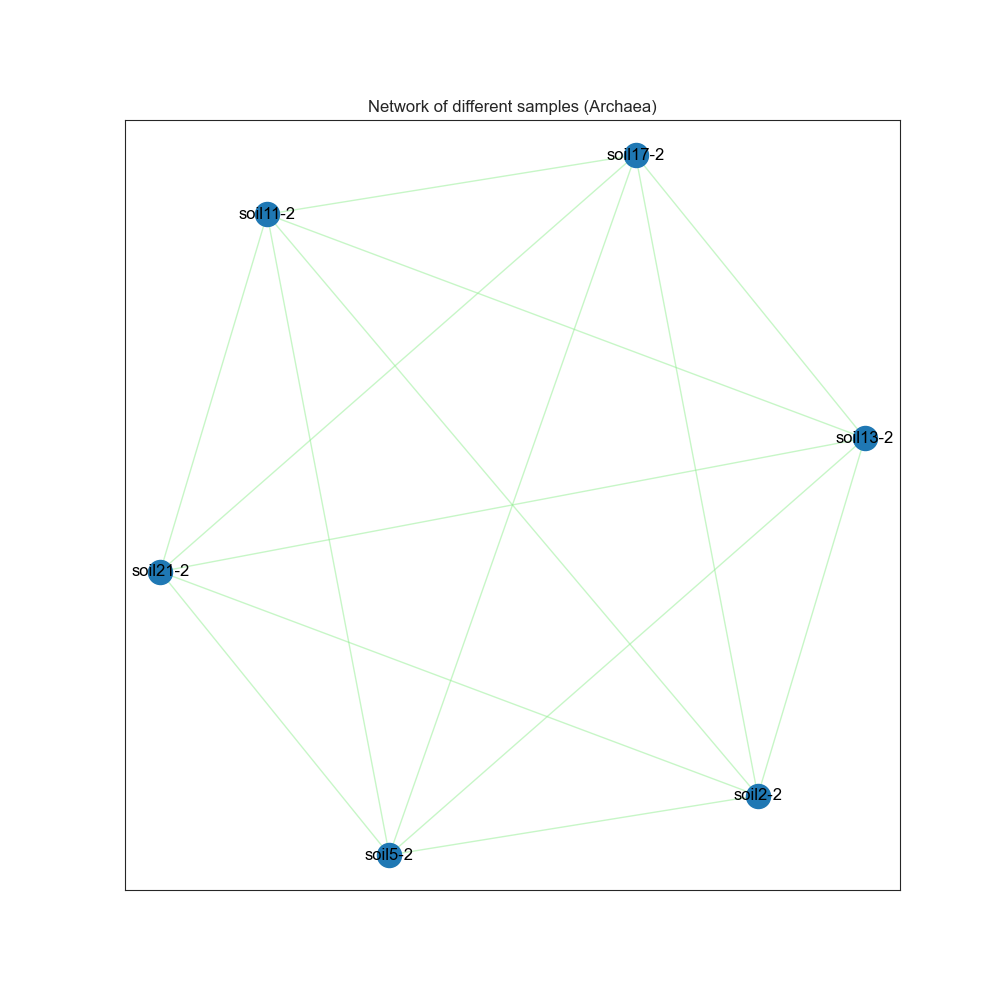

In [42]:
# Load the distance matrix as a QIIME 2 artifact
distance_matrix_artifact = diversity.methods.pcoa(distance_matrix_a.distance_matrix)
distance_matrix_data = distance_matrix_artifact.pcoa.view(qiime2.Metadata)
distM = distance_matrix_data.to_dataframe().values
sample_ids = distance_matrix_data.ids

# Create a graph using NetworkX
G = nx.Graph()

# Add nodes (samples) to the graph
G.add_nodes_from(sample_ids)

# Add edges (connections) between nodes based on the distance matrix and threshold
num_samples = len(sample_ids)
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        G.add_edge(sample_ids[i], sample_ids[j])
            
# Draw the graph
# Plot the network
plt.figure(figsize=(10, 10))
plt.title("Network of different samples (Archaea)")
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='lightgreen')
nx.draw_networkx_labels(G, pos)
plt.show()

<IPython.core.display.Javascript object>


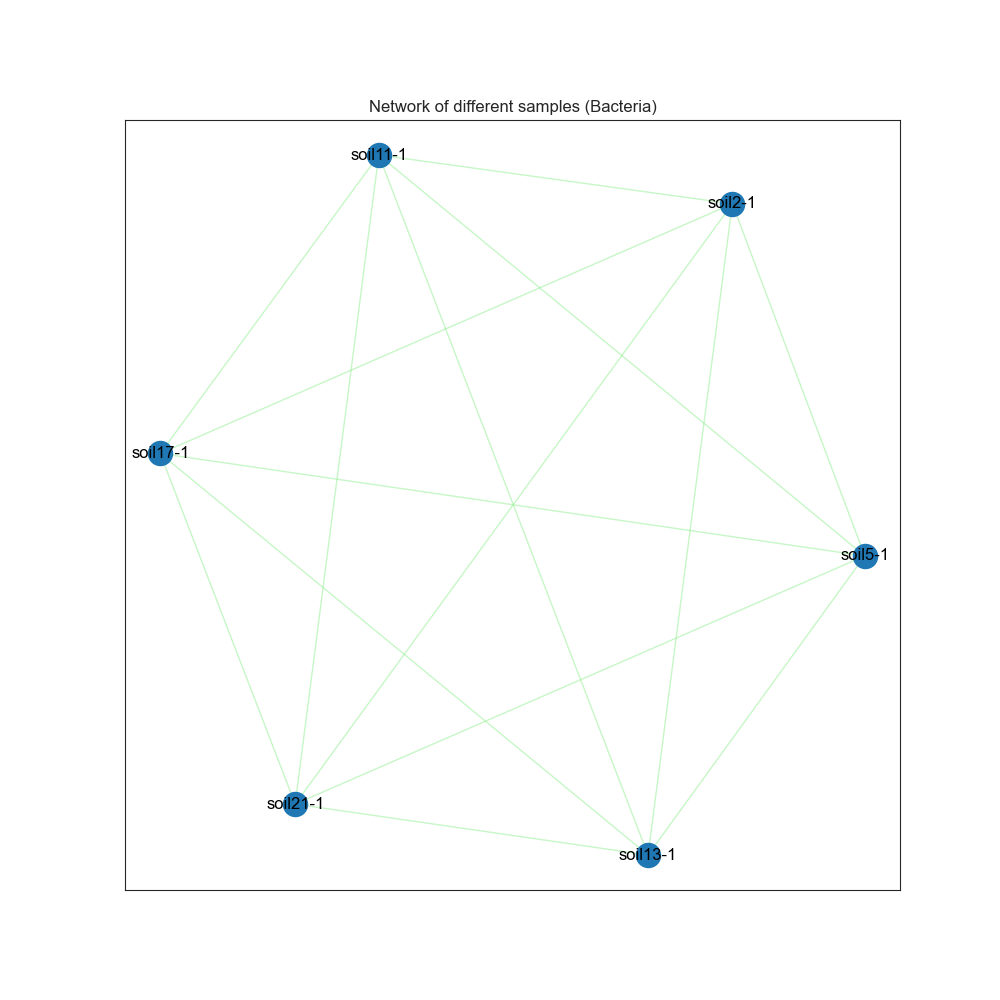

In [43]:
# Load the distance matrix as a QIIME 2 artifact
distance_matrix_artifact = diversity.methods.pcoa(distance_matrix_b.distance_matrix)
distance_matrix_data = distance_matrix_artifact.pcoa.view(qiime2.Metadata)
distM = distance_matrix_data.to_dataframe().values
sample_ids = distance_matrix_data.ids

# Create a graph using NetworkX
G = nx.Graph()

# Add nodes (samples) to the graph
G.add_nodes_from(sample_ids)

# Add edges (connections) between nodes based on the distance matrix and threshold
num_samples = len(sample_ids)
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        G.add_edge(sample_ids[i], sample_ids[j])
            
# Draw the graph
# Plot the network
plt.figure(figsize=(10, 10))
plt.title("Network of different samples (Bacteria)")
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='lightgreen')
nx.draw_networkx_labels(G, pos)
plt.show()

<IPython.core.display.Javascript object>


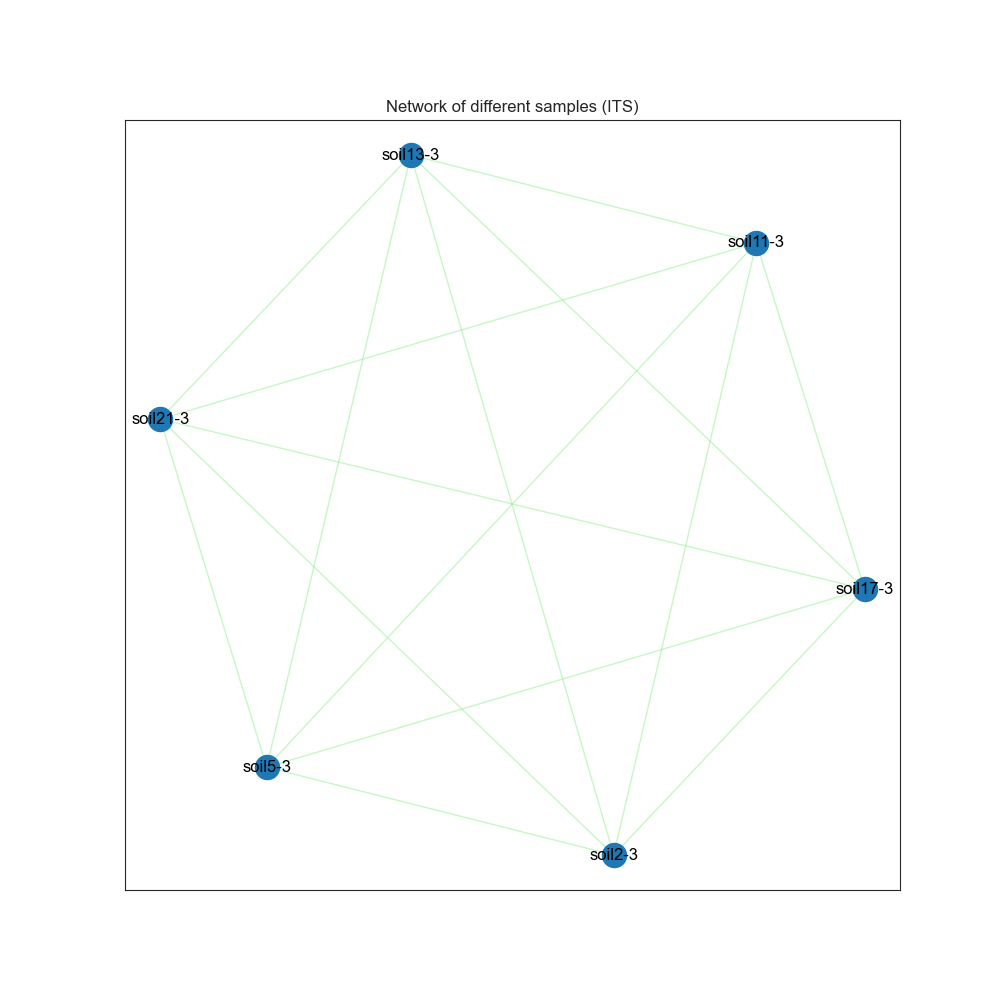

In [44]:
# Load the distance matrix as a QIIME 2 artifact
distance_matrix_artifact = diversity.methods.pcoa(distance_matrix_i.distance_matrix)
distance_matrix_data = distance_matrix_artifact.pcoa.view(qiime2.Metadata)
distM = distance_matrix_data.to_dataframe().values
sample_ids = distance_matrix_data.ids

# Create a graph using NetworkX
G = nx.Graph()

# Add nodes (samples) to the graph
G.add_nodes_from(sample_ids)

# Add edges (connections) between nodes based on the distance matrix and threshold
num_samples = len(sample_ids)
for i in range(num_samples):
    for j in range(i + 1, num_samples):
        G.add_edge(sample_ids[i], sample_ids[j])
            
# Draw the graph
# Plot the network
plt.figure(figsize=(10, 10))
plt.title("Network of different samples (ITS)")
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='lightgreen')
nx.draw_networkx_labels(G, pos)
plt.show()

### List of highly diverse microbes

In [45]:
# Perform rarefaction to a specific depth
rarefied_table = feature_table.methods.rarefy(
                            table=table_a,
                            sampling_depth=4446)

In [46]:
# Calculate diversity metrics (e.g., Shannon index)
diversity_result = diversity.pipelines.alpha(
                        table=rarefied_table.rarefied_table,
                        metric='shannon')

# Access and analyze diversity values for each sample
diversity_values = diversity_result.alpha_diversity

In [47]:
diversity_df = diversity_result.alpha_diversity.view(qiime2.Metadata).to_dataframe()

In [48]:
# Define the threshold for identifying highly diverse samples
threshold = 5.0

# Filter samples with Shannon entropy values above the threshold
highly_diverse_samples = diversity_df[diversity_df['shannon_entropy'] > threshold]

print(highly_diverse_samples)

           shannon_entropy
Sample ID                 
soil11-2          5.792445


In [49]:
# Perform rarefaction to a specific depth
rarefied_table = feature_table.methods.rarefy(
                            table=table_b,
                            sampling_depth=5000)

In [50]:
# Calculate diversity metrics (e.g., Shannon index)
diversity_result = diversity.pipelines.alpha(
                        table=rarefied_table.rarefied_table,
                        metric='shannon')

# Access and analyze diversity values for each sample
diversity_values = diversity_result.alpha_diversity

In [51]:
diversity_df = diversity_result.alpha_diversity.view(qiime2.Metadata).to_dataframe()
# Define the threshold for identifying highly diverse samples
threshold = 6.0

# Filter samples with Shannon entropy values above the threshold
highly_diverse_samples = diversity_df[diversity_df['shannon_entropy'] > threshold]

print(highly_diverse_samples)

           shannon_entropy
Sample ID                 
soil11-1          6.273108


In [52]:
# Perform rarefaction to a specific depth
rarefied_table = feature_table.methods.rarefy(
                            table=table_i,
                            sampling_depth=12000)

In [53]:
# Calculate diversity metrics (e.g., Shannon index)
diversity_result = diversity.pipelines.alpha(
                        table=rarefied_table.rarefied_table,
                        metric='shannon')

# Access and analyze diversity values for each sample
diversity_values = diversity_result.alpha_diversity

In [54]:
diversity_df = diversity_result.alpha_diversity.view(qiime2.Metadata).to_dataframe()
# Define the threshold for identifying highly diverse samples
threshold = 2.0

# Filter samples with Shannon entropy values above the threshold
highly_diverse_samples = diversity_df[diversity_df['shannon_entropy'] > threshold]

print(highly_diverse_samples)

           shannon_entropy
Sample ID                 
soil13-3          2.302331


### Comparative analysis between amplicon types

In [87]:
# Phylogeny align-to-tree-mafft-fasttree
phylo_tree_a = phylogeny.pipelines.align_to_tree_mafft_fasttree(representative_sequences_a)

save_results(phylo_tree_a, "output/archaea/tree")

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 /tmp/qiime2-archive-06pwsue2/61d2df3a-c9e9-4410-abcf-59a0d9a7a013/data/dna-sequences.fasta

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTree -quote -nt /tmp/qiime2-archive-zbe72zpz/96ac9cac-0f21-4607-b4ba-c348e9518b4c/data/aligned-dna-sequences.fasta

Saved matrix alignment successfully at output/archaea/tree/alignment.qza.
Saved matrix masked_alignment successfully at output/archaea/tree/masked_alignment.qza.
Saved matrix tree successfully at output/archaea/tree/tree.qza.
Saved matrix rooted_tree successfully at output/archa

In [88]:
# Empress tree-plot
#tree = qiime2.Artifact.load("tree/rooted_tree.qza")
emp_tree_plot = empress.visualizers.tree_plot(phylo_tree_a.rooted_tree)
emp_tree_plot.visualization.save("output/archaea/tree/rooted_tree.qzv")

/home/ikraminf/anaconda3/envs/ngs/lib/python3.6/site-packages/empress/tree.py:81: TreeFormatWarning: Internal node names in the tree are not unique.
  TreeFormatWarning


'output/archaea/tree/rooted_tree.qzv'

In [89]:
emp_tree_plot.visualization

<visualization: Visualization uuid: 163dd383-6739-41e5-a0d1-8abc66540646>

In [90]:
alpha_rarefaction_viz = diversity.visualizers.alpha_rarefaction(
                            table=table_a,
                            max_depth=4000, # around 10-20% higher than minimum read count
                            phylogeny=phylo_tree_a.rooted_tree,
                            metadata=metadata)

alpha_rarefaction_viz.visualization

<visualization: Visualization uuid: 3fc8351f-9f9d-4fef-87e7-db974747bbe8>

In [91]:
# Core metrics phylogenetic
core_metrics = diversity.pipelines.core_metrics_phylogenetic(
    table=table_a,
    phylogeny=phylo_tree_a.rooted_tree,
    sampling_depth=2100,
    metadata=metadata)

/home/ikraminf/anaconda3/envs/ngs/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [92]:
# Make sure to replace these with actual variable names and output directory
save_results(core_metrics, "output/archaea/diversity/")

Saved matrix rarefied_table successfully at output/archaea/diversity/rarefied_table.qza.
Saved matrix faith_pd_vector successfully at output/archaea/diversity/faith_pd_vector.qza.
Saved matrix observed_features_vector successfully at output/archaea/diversity/observed_features_vector.qza.
Saved matrix shannon_vector successfully at output/archaea/diversity/shannon_vector.qza.
Saved matrix evenness_vector successfully at output/archaea/diversity/evenness_vector.qza.
Saved matrix unweighted_unifrac_distance_matrix successfully at output/archaea/diversity/unweighted_unifrac_distance_matrix.qza.
Saved matrix weighted_unifrac_distance_matrix successfully at output/archaea/diversity/weighted_unifrac_distance_matrix.qza.
Saved matrix jaccard_distance_matrix successfully at output/archaea/diversity/jaccard_distance_matrix.qza.
Saved matrix bray_curtis_distance_matrix successfully at output/archaea/diversity/bray_curtis_distance_matrix.qza.
Saved matrix unweighted_unifrac_pcoa_results successful

In [93]:
alpha_group_significance_faith = diversity.visualizers.alpha_group_significance(
    alpha_diversity=core_metrics.faith_pd_vector,
    metadata=metadata)

In [94]:
alpha_group_significance_faith.visualization

<visualization: Visualization uuid: ab92293d-f2b5-4eb1-bff0-5dc76a320d98>

In [95]:
core_metrics.unweighted_unifrac_emperor

<visualization: Visualization uuid: 1cd32f67-1580-49e7-bfaf-f60b99a82c4b>

In [96]:
core_metrics.weighted_unifrac_emperor

<visualization: Visualization uuid: 9c0ae92a-8e14-44ce-a8d6-47e00b478d07>

In [97]:
core_metrics.jaccard_emperor

<visualization: Visualization uuid: 26c83905-ea49-4f22-92b1-c788adcb82ed>

In [98]:
core_metrics.bray_curtis_emperor

<visualization: Visualization uuid: b483a17e-e1a3-411d-93fa-e974587fd550>

In [99]:
# Phylogeny align-to-tree-mafft-fasttree
phylo_tree_b = phylogeny.pipelines.align_to_tree_mafft_fasttree(representative_sequences_b)

save_results(phylo_tree_b, "output/bacteria/tree")

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 /tmp/qiime2-archive-_p3y_89s/5e4cc9d4-59eb-4748-a454-e799327545b4/data/dna-sequences.fasta

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTree -quote -nt /tmp/qiime2-archive-98zs9e7x/0b463a4c-3dc3-43c5-99b7-66268b787b85/data/aligned-dna-sequences.fasta

Saved matrix alignment successfully at output/bacteria/tree/alignment.qza.
Saved matrix masked_alignment successfully at output/bacteria/tree/masked_alignment.qza.
Saved matrix tree successfully at output/bacteria/tree/tree.qza.
Saved matrix rooted_tree successfully at output/ba

In [100]:
# Empress tree-plot
#tree = qiime2.Artifact.load("tree/rooted_tree.qza")
emp_tree_plot = empress.visualizers.tree_plot(phylo_tree_b.rooted_tree)
emp_tree_plot.visualization.save("output/bacteria/tree/rooted_tree.qzv")
emp_tree_plot.visualization

/home/ikraminf/anaconda3/envs/ngs/lib/python3.6/site-packages/empress/tree.py:81: TreeFormatWarning: Internal node names in the tree are not unique.
  TreeFormatWarning


<visualization: Visualization uuid: 4bc92614-a5f0-4051-b6fa-f69fe22ff9ce>

In [101]:
alpha_rarefaction_viz = diversity.visualizers.alpha_rarefaction(
                            table=table_b,
                            max_depth=5000, # around 10-20% higher than minimum read count
                            phylogeny=phylo_tree_b.rooted_tree,
                            metadata=metadata)

alpha_rarefaction_viz.visualization

<visualization: Visualization uuid: faa21a26-11d1-443f-901d-5dc1c736a7b0>

In [102]:
# Core metrics phylogenetic
core_metrics = diversity.pipelines.core_metrics_phylogenetic(
    table=table_b,
    phylogeny=phylo_tree_b.rooted_tree,
    sampling_depth=500,
    metadata=metadata)

/home/ikraminf/anaconda3/envs/ngs/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [103]:
# Make sure to replace these with actual variable names and output directory
save_results(core_metrics, "output/bacteria/diversity/")

Saved matrix rarefied_table successfully at output/bacteria/diversity/rarefied_table.qza.
Saved matrix faith_pd_vector successfully at output/bacteria/diversity/faith_pd_vector.qza.
Saved matrix observed_features_vector successfully at output/bacteria/diversity/observed_features_vector.qza.
Saved matrix shannon_vector successfully at output/bacteria/diversity/shannon_vector.qza.
Saved matrix evenness_vector successfully at output/bacteria/diversity/evenness_vector.qza.
Saved matrix unweighted_unifrac_distance_matrix successfully at output/bacteria/diversity/unweighted_unifrac_distance_matrix.qza.
Saved matrix weighted_unifrac_distance_matrix successfully at output/bacteria/diversity/weighted_unifrac_distance_matrix.qza.
Saved matrix jaccard_distance_matrix successfully at output/bacteria/diversity/jaccard_distance_matrix.qza.
Saved matrix bray_curtis_distance_matrix successfully at output/bacteria/diversity/bray_curtis_distance_matrix.qza.
Saved matrix unweighted_unifrac_pcoa_results s

In [104]:
alpha_group_significance_faith = diversity.visualizers.alpha_group_significance(
    alpha_diversity=core_metrics.faith_pd_vector,
    metadata=metadata)

alpha_group_significance_faith.visualization

<visualization: Visualization uuid: 4e3f0d3c-bc35-4642-8c5a-54abbcb68452>

In [105]:
core_metrics.unweighted_unifrac_emperor

<visualization: Visualization uuid: a46fba35-01de-4042-a02d-3e59b3c66d75>

In [106]:
core_metrics.weighted_unifrac_emperor

<visualization: Visualization uuid: 66955ea6-63da-4530-a182-87ed8e9fa45f>

In [107]:
core_metrics.jaccard_emperor

<visualization: Visualization uuid: 0dacec3d-aee1-4d2b-a144-25fc75d187d6>

In [108]:
core_metrics.bray_curtis_emperor

<visualization: Visualization uuid: 59110efb-618f-4dc0-b061-51c41874e2ae>

In [109]:
# Phylogeny align-to-tree-mafft-fasttree
phylo_tree_i = phylogeny.pipelines.align_to_tree_mafft_fasttree(representative_sequences_i)

save_results(phylo_tree_i, "output/its/tree")

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: mafft --preservecase --inputorder --thread 1 /tmp/qiime2-archive-pb4jbkrh/6d2203c5-8034-4d0c-920f-f02679d0ae43/data/dna-sequences.fasta

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: FastTree -quote -nt /tmp/qiime2-archive-53i45n5q/99ab6f79-11db-43ff-a853-413d9849f502/data/aligned-dna-sequences.fasta

Saved matrix alignment successfully at output/its/tree/alignment.qza.
Saved matrix masked_alignment successfully at output/its/tree/masked_alignment.qza.
Saved matrix tree successfully at output/its/tree/tree.qza.
Saved matrix rooted_tree successfully at output/its/tree/rooted_t

In [110]:
# Empress tree-plot
#tree = qiime2.Artifact.load("tree/rooted_tree.qza")
emp_tree_plot = empress.visualizers.tree_plot(phylo_tree_i.rooted_tree)
emp_tree_plot.visualization.save("output/its/tree/rooted_tree.qzv")
emp_tree_plot.visualization

/home/ikraminf/anaconda3/envs/ngs/lib/python3.6/site-packages/empress/tree.py:81: TreeFormatWarning: Internal node names in the tree are not unique.
  TreeFormatWarning


<visualization: Visualization uuid: 0b1c6f44-cd3c-4d47-b042-16e42b1f339e>

In [111]:
alpha_rarefaction_viz = diversity.visualizers.alpha_rarefaction(
                            table=table_i,
                            max_depth=4000, # around 10-20% higher than minimum read count
                            phylogeny=phylo_tree_i.rooted_tree,
                            metadata=metadata)

alpha_rarefaction_viz.visualization

<visualization: Visualization uuid: 5a27559d-aa0c-4d58-aaa2-e9a2d93a1260>

In [112]:
# Core metrics phylogenetic
core_metrics = diversity.pipelines.core_metrics_phylogenetic(
    table=table_i,
    phylogeny=phylo_tree_i.rooted_tree,
    sampling_depth=2100,
    metadata=metadata)

/home/ikraminf/anaconda3/envs/ngs/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [113]:
# Make sure to replace these with actual variable names and output directory
save_results(core_metrics, "output/its/diversity/")

Saved matrix rarefied_table successfully at output/its/diversity/rarefied_table.qza.
Saved matrix faith_pd_vector successfully at output/its/diversity/faith_pd_vector.qza.
Saved matrix observed_features_vector successfully at output/its/diversity/observed_features_vector.qza.
Saved matrix shannon_vector successfully at output/its/diversity/shannon_vector.qza.
Saved matrix evenness_vector successfully at output/its/diversity/evenness_vector.qza.
Saved matrix unweighted_unifrac_distance_matrix successfully at output/its/diversity/unweighted_unifrac_distance_matrix.qza.
Saved matrix weighted_unifrac_distance_matrix successfully at output/its/diversity/weighted_unifrac_distance_matrix.qza.
Saved matrix jaccard_distance_matrix successfully at output/its/diversity/jaccard_distance_matrix.qza.
Saved matrix bray_curtis_distance_matrix successfully at output/its/diversity/bray_curtis_distance_matrix.qza.
Saved matrix unweighted_unifrac_pcoa_results successfully at output/its/diversity/unweighte

In [114]:
alpha_group_significance_faith = diversity.visualizers.alpha_group_significance(
    alpha_diversity=core_metrics.faith_pd_vector,
    metadata=metadata)

alpha_group_significance_faith.visualization

<visualization: Visualization uuid: 2cad0a33-9eb3-4f44-9d67-8c3227c62bf2>

In [115]:
core_metrics.unweighted_unifrac_emperor

<visualization: Visualization uuid: 2dc2f688-0efd-4654-81b8-8291ec89ffa7>

In [116]:
core_metrics.weighted_unifrac_emperor

<visualization: Visualization uuid: 45f6ee4e-03f6-40b5-96f8-b57479f7b043>

In [117]:
core_metrics.jaccard_emperor

<visualization: Visualization uuid: 65e4cab9-4fe1-4131-89fc-955dd7ae37bf>

In [118]:
core_metrics.bray_curtis_emperor

<visualization: Visualization uuid: 4594e744-92ae-4fb7-81ae-65e52df950a7>